In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from matplotlib.path import Path


In [10]:

# ============================================================
# --- VORONOI HELPERS ---
# ============================================================

def voronoi_finite_polygons_2d(vor, radius=1000):
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    all_ridges = {}

    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region_index in enumerate(vor.point_region):
        region = vor.regions[region_index]
        if -1 not in region:
            new_regions.append(region)
            continue

        ridges = all_ridges[p1]
        new_region = [v for v in region if v != -1]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue

            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            new_vertices.append(far_point.tolist())
            new_region.append(len(new_vertices) - 1)

        new_regions.append(new_region)

    return new_regions, np.array(new_vertices)

def sort_polygon(points):
    center = points.mean(axis=0)
    angles = np.arctan2(points[:,1] - center[1], points[:,0] - center[0])
    return points[np.argsort(angles)]


In [11]:

# ============================================================
# --- SIMULATION PARAMETERS ---
# ============================================================

WIDTH = 380
HEIGHT = 280
NUM_DISTRICTS = 8       # Number of districts
NUM_DOTS = 100          # Number of voters
COLORS = ['red', 'blue', 'green'] # Parties (for efficiency gap and PR)
NUM_RUNS = 10           # Number of simulations

# ============================================================
# --- CREATE FIXED DISTRICT MAP (run once) ---
# ============================================================

points = np.random.rand(NUM_DISTRICTS, 2)
points[:,0] *= WIDTH
points[:,1] *= HEIGHT
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor)

# Store fixed district polygons
district_polygons = []
for region in regions:
    polygon = vertices[region]
    if len(polygon) < 3:
        district_polygons.append(None)
    else:
        district_polygons.append(sort_polygon(polygon))


In [12]:

# ============================================================
# --- FUNCTION: run one election with random voters ---
# ============================================================

def run_election():
    """
    Generates random voters and counts them per district.
    Returns:
        dots_x, dots_y, dots_colors, district_counts
    """
    dots_x = np.random.rand(NUM_DOTS) * WIDTH
    dots_y = np.random.rand(NUM_DOTS) * HEIGHT
    dots_colors = np.random.choice(COLORS, NUM_DOTS)

    district_counts = []
    for polygon in district_polygons:
        counts = {color: 0 for color in COLORS}
        if polygon is None:
            district_counts.append(counts)
            continue
        poly_path = Path(polygon)
        mask = poly_path.contains_points(np.column_stack((dots_x, dots_y)))
        for color, inside in zip(dots_colors, mask):
            if inside:
                counts[color] += 1
        district_counts.append(counts)

    return dots_x, dots_y, dots_colors, district_counts



In [13]:
# ============================================================
# --- FUNCTION: calculate proportional representation ---
# ============================================================

def calculate_PR(district_counts):
    """
    Returns a dictionary of allocated seats per party using largest remainder method.
    """
    NUM_SEATS = NUM_DISTRICTS

    # Compute statewide votes
    statewide_votes = {color: 0 for color in COLORS}
    for district in district_counts:
        for color in COLORS:
            statewide_votes[color] += district[color]

    total_votes = sum(statewide_votes.values())
    exact_seats = {color: (statewide_votes[color]/total_votes)*NUM_SEATS for color in COLORS}

    # Assign integer seats first
    allocated_seats = {color: int(exact_seats[color]) for color in COLORS}
    remaining_seats = NUM_SEATS - sum(allocated_seats.values())

    # Largest remainder method
    remainders = {color: exact_seats[color] - allocated_seats[color] for color in COLORS}
    sorted_by_remainder = sorted(COLORS, key=lambda c: remainders[c], reverse=True)
    for i in range(remaining_seats):
        allocated_seats[sorted_by_remainder[i]] += 1

    return statewide_votes, allocated_seats


In [18]:
# ============================================================
# --- RUN SIMULATIONS ---
# ============================================================

all_results = []

for run in range(NUM_RUNS):
    dots_x, dots_y, dots_colors, district_counts = run_election()
    statewide_votes, allocated_seats = calculate_PR(district_counts)


    all_results.append({
        'statewide_votes': statewide_votes,
        'allocated_seats': allocated_seats,
        'dots_x': dots_x,
        'dots_y': dots_y,
        'dots_colors': dots_colors
    })


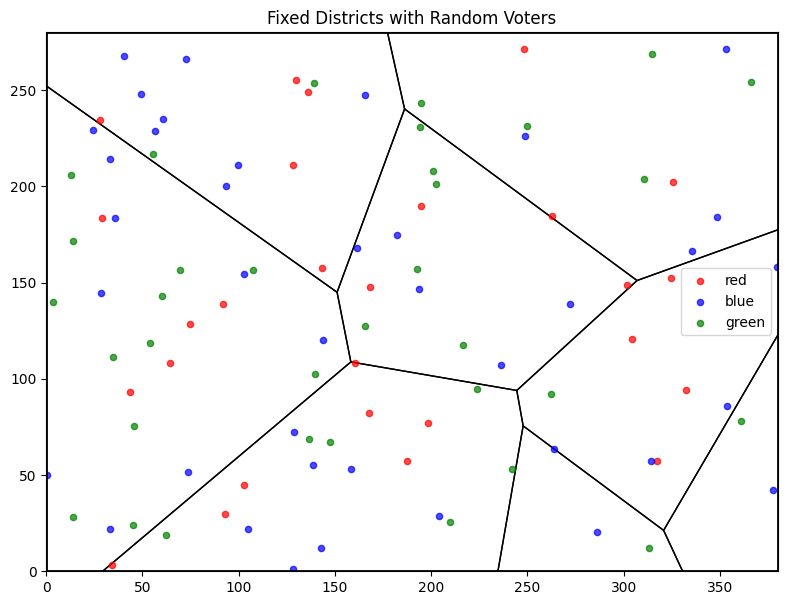


--- Simulation 1 ---
Statewide votes: {'red': 27, 'blue': 39, 'green': 34}
Allocated seats: {'red': 2, 'blue': 3, 'green': 3}

--- Simulation 2 ---
Statewide votes: {'red': 33, 'blue': 37, 'green': 30}
Allocated seats: {'red': 3, 'blue': 3, 'green': 2}

--- Simulation 3 ---
Statewide votes: {'red': 41, 'blue': 27, 'green': 32}
Allocated seats: {'red': 3, 'blue': 2, 'green': 3}

--- Simulation 4 ---
Statewide votes: {'red': 27, 'blue': 30, 'green': 43}
Allocated seats: {'red': 2, 'blue': 2, 'green': 4}

--- Simulation 5 ---
Statewide votes: {'red': 30, 'blue': 34, 'green': 36}
Allocated seats: {'red': 2, 'blue': 3, 'green': 3}


In [ ]:
# ============================================================
# ---  visualize one run ---
# ============================================================

run_to_show = 0
dots_x = all_results[run_to_show]['dots_x']
dots_y = all_results[run_to_show]['dots_y']
dots_colors = all_results[run_to_show]['dots_colors']

fig, ax = plt.subplots(figsize=(10,7))
for polygon in district_polygons:
    if polygon is not None:
        ax.fill(polygon[:,0], polygon[:,1], edgecolor='black', fill=False, linewidth=1)

for color in COLORS:
    ax.scatter(dots_x[dots_colors==color], dots_y[dots_colors==color], c=color, label=color, s=20, alpha=0.7)

ax.plot([0, WIDTH, WIDTH, 0, 0], [0,0,HEIGHT,HEIGHT,0], color='black', linewidth=2)
ax.set_xlim(0, WIDTH)
ax.set_ylim(0, HEIGHT)
ax.set_aspect('equal')
ax.set_title('Fixed Districts with Random Voters')
ax.legend()
plt.show()

# ============================================================
# --- SHOW RESULTS ---
# ============================================================

for i, result in enumerate(all_results[:5]):  # show first 5 runs
    print(f"\n--- Simulation {i+1} ---")
    print("Statewide votes:", result['statewide_votes'])
    print("Candidate Vote/Total Vote:", statewide_votes[color]/total_votes )
    print("Allocated seats:", result['allocated_seats'])


